
>**NNFC Project - Detection of Social distancing and mask violation for surveillance systems (WINTER SEMESTER 2020 - 2021)** 




---


* Rahul Gowlapalli - 19BEC0547
* Sourya Mukherjee - 19BEC432
* Ashish Akarsh - 19BEC0562
* Aastha Singh - 19BEC0339
* Tamal Kumar - 19BEC0731 






---
**Submitted to : Dr. Vaegae Naveen Kumar** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd Social-Distancing-Analyser-and-Mask-Monitoring-AI-system-wrt-Covid-19/


/content/drive/MyDrive/tarp_project/Social-Distancing-Analyser-and-Mask-Monitoring-AI-system-wrt-Covid-19


In [ ]:
# Install Required Libraries from PyPI
!pip install face-detection
!pip install tqdm

  Created wheel for face-detection: filename=face_detection-0.2.2-py3-none-any.whl size=25574 sha256=7ec4901a829c33dfa1f75490d009ccdf5b728acfb6b90c1b8b03f648582107c2
  Stored in directory: /root/.cache/pip/wheels/dd/2d/84/c7a9ce1760b00f8b1d431c9564b108acfb98f588c18d4a1a9c
Successfully built face-detection


In [ ]:
# Import Required Libraries
import time
import math
import os
import numpy as np
import cv2
import face_detection 
from keras.models import load_model
from keras.applications.resnet import preprocess_input
import tqdm
import imutils
from google.colab.patches import cv2_imshow

In [ ]:
conf_threshold = 0.1
nms_threshold = 0.1
angle_factor = 0.4
H_zoom_factor = 1.2


In [ ]:
def dist(c1, c2):
    return ((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2) ** 0.5

def T2S(T):
    S = abs(T/((1+T**2)**0.5))
    return S

def T2C(T):
    C = abs(1/((1+T**2)**0.5))
    return C

def isclose(p1,p2):

    c_d = dist(p1[2], p2[2])
    if(p1[1]<p2[1]):
        a_w = p1[0]
        a_h = p1[1]
    else:
        a_w = p2[0]
        a_h = p2[1]

    T = 0
    try:
        T=(p2[2][1]-p1[2][1])/(p2[2][0]-p1[2][0])
    except ZeroDivisionError:
        T = 1.633123935319537e+16
    S = T2S(T)
    C = T2C(T)
    d_hor = C*c_d
    d_ver = S*c_d
    vc_calib_hor = a_w*1.3
    vc_calib_ver = a_h*0.4*angle_factor
    c_calib_hor = a_w *1.7
    c_calib_ver = a_h*0.2*angle_factor
    # print(p1[2], p2[2],(vc_calib_hor,d_hor),(vc_calib_ver,d_ver))
    if (0<d_hor<vc_calib_hor and 0<d_ver<vc_calib_ver):
        return 1
    elif 0<d_hor<c_calib_hor and 0<d_ver<c_calib_ver:
        return 2
    else:
        return 0

In [ ]:
cd ..

/content/drive/MyDrive/tarp_project


In [ ]:
# Path to the Working Environment

# If using Google Colab (If on a Local Environment, no path required => set BASE_PATH  = "")
BASE_PATH = "Social-Distancing-Analyser-and-Mask-Monitoring-AI-system-wrt-Covid-19/"

# Path to Input Video File in the BASE_PATH
FILE_PATH = "example.mp4"

In [ ]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces
detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

Downloading: "https://folk.ntnu.no/haakohu/WIDERFace_DSFD_RES152.pth" to /root/.cache/torch/hub/checkpoints/WIDERFace_DSFD_RES152.pth


  0%|          | 0.00/459M [00:00<?, ?B/s]

In [ ]:
cd ..

/content/drive/MyDrive/tarp_project


In [ ]:
mask_classifier = load_model("Social-Distancing-Analyser-and-Mask-Monitoring-AI-system-wrt-Covid-19/models/ResNet50_Classifier.h5")

In [ ]:
##################################### Analyze the Video ################################################

# Load YOLOv3
net = cv2.dnn.readNet(BASE_PATH+"models/"+"yolov3-spp.weights", BASE_PATH+"models/"+"yolov3-spp.cfg")

# Load COCO Classes
LABELS  = []
with open(BASE_PATH+"models/"+"coco.names", "r") as f:
    LABELS = [line.strip() for line in f.readlines()]

np.random.seed(42)

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
FR=0
# Fetch Video Properties
vs = cv2.VideoCapture(BASE_PATH + FILE_PATH )
fps = vs.get(cv2.CAP_PROP_FPS)
print(fps)
# width1 = vs.get(cv2.CAP_PROP_FRAME_WIDTH)
# height1 = vs.get(cv2.CAP_PROP_FRAME_HEIGHT)
n_frames = vs.get(cv2.CAP_PROP_FRAME_COUNT)
print(n_frames)
writer = None
(W, H) = (None, None)

fl = 0
q = 0
# Create Directory for Storing Results (Make sure it doesn't already exists !)

# Initialize Output Video Stream
# out_stream = cv2.VideoWriter(
#     BASE_PATH+'Results/test.mp4',
#     cv2.VideoWriter_fourcc('X','V','I','D'),
#     fps,
#     (int(width),int(height)))

print("Processing Frames :")
for feed in tqdm.notebook.tqdm(range(int(n_frames))):
  
    # Capture Frame-by-Frame
    (grabbed, frame) = vs.read()
    frame = imutils.resize(frame, width=1280,height=720)
    # Check EOF
    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]
        FW=W
        # if(W<1075):
        #     FW = 1075
        FR = np.zeros((H+210,FW,3), np.uint8)

        col = (255,255,255)
        FH = H + 210
    FR[:] = col

    # Detect Objects in the Frame with YOLOv3
    # blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (608, 608), swapRB=True, crop=False)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0 , (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    start = time.time()
    outs = net.forward(output_layers)
    end = time.time()

    classIDs  = []
    confidences = []
    boxes = []
    
    # Store Detected Objects with Labels, Bounding_Boxes and their Confidences
    for out in outs:

        for detection in out:


            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if LABELS[classID] == "person":
                if confidence > conf_threshold:
                
                    # Get Center, Height and Width of the Box
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    
                
                    # Topleft Co-ordinates
                    # x = int(center_x - w / 2)
                    # y = int(center_y - h / 2)

                    boxes.append([x, y,int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,nms_threshold)

    # Initialize empty lists for storing Bounding Boxes of People and their Faces
    

    # Work on Detected Persons in the Frame
    if len(idxs) > 0:
        persons = []
        masked_faces = []
        unmasked_faces = []
        status = []
        idf = idxs.flatten()
        close_pair = []
        s_close_pair = []
        center = []
        co_info = []

        for i in idf:

            # (x, y) = (boxes[i][0], boxes[i][1])
            # (w, h) = (boxes[i][2], boxes[i][3])
            box = np.array(boxes[i])
            box = np.where(box<0,0,box)
            (x, y, w, h) = box
            cen = [int(x + w / 2), int(y + h / 2)]
            center.append(cen)
            cv2.circle(frame, tuple(cen),1,(0,0,0),1)
            co_info.append([w, h, cen])

            status.append(0)
            persons.append([x,y,w,h])
                
                # Detect Face in the Person
            person_rgb = frame[y:y+h,x:x+w,::-1]   # Crop & BGR to RGB
            detections = detector.detect(person_rgb)

                # If a Face is Detected
            if detections.shape[0] > 0:

                detection = np.array(detections[0])
                detection = np.where(detection<0,0,detection)

                # Calculating Co-ordinates of the Detected Face
                x1 = x + int(detection[0])
                x2 = x + int(detection[2])
                y1 = y + int(detection[1])
                y2 = y + int(detection[3])

                try :


                    # Crop & BGR to RGB
                    face_rgb = frame[y1:y2,x1:x2,::-1]  

                    # Preprocess the Image
                    face_arr = cv2.resize(face_rgb, (224, 224), interpolation=cv2.INTER_NEAREST)
                    face_arr = np.expand_dims(face_arr, axis=0)
                    face_arr = preprocess_input(face_arr)

                    # Predict if the Face is Masked or Not
                    score = mask_classifier.predict(face_arr)

                    # Determine and store Results
                    if score[0][0]<0.10:
                        masked_faces.append([x1,y1,x2,y2])
                    else:
                        unmasked_faces.append([x1,y1,x2,y2])

                except:
                    continue
        masked_face_count = len(masked_faces)
        unmasked_face_count = len(unmasked_faces)
        for i in range(len(center)):
            for j in range(len(center)):
    
                g = isclose(co_info[i],co_info[j])

                if g == 1:

                    close_pair.append([center[i], center[j]])
                    status[i] = 1
                    status[j] = 1
                elif g == 2:
                    s_close_pair.append([center[i], center[j]])
                    if status[i] != 1:
                        status[i] = 2
                    if status[j] != 1:
                        status[j] = 2
        total_p = len(center)
        low_risk_p = status.count(2)
        high_risk_p = status.count(1)
        safe_p = status.count(0)
        kk = 0                       
        for i in idf:
            cv2.line(FR,(0,H+1),(FW,H+1),(0,0,0),2)
            cv2.putText(FR, "Social Distancing Analyser and Mask Monitoring wrt. COVID-19", (210, H+60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.rectangle(FR, (20, H+80), (510, H+180), (100, 100, 100), 2)
            cv2.putText(FR, "Connecting lines shows closeness among people. ", (30, H+100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 100, 0), 2)
            cv2.putText(FR, "-- YELLOW: CLOSE", (50, H+90+40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 170, 170), 2)
            cv2.putText(FR, "--    RED: VERY CLOSE", (50, H+40+110),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            # cv2.putText(frame, "--    PINK: Pathway for Calibration", (50, 150),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (180,105,255), 1)

            cv2.rectangle(FR, (535, H+80), (1250, H+140+40), (100, 100, 100), 2)
            cv2.putText(FR, "Bounding box shows the level of risk to the person and Mask Monitoring", (545, H+100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 100, 0), 2)
            cv2.putText(FR, "-- LIGHT GREEN: SAFE", (565,  H+90+40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(FR, "-- Green: MASKED", (865, H+90+40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 100, 0), 2)
            cv2.putText(FR, "--    DARK RED: HIGH RISK", (565, H+150),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 150), 2)
            cv2.putText(FR, "--   RED: UNMASKED", (865, H+150),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.putText(FR, "--      ORANGE: LOW RISK", (565, H+170),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 120, 255), 2)
            
            tot_str = "TOTAL COUNT:" + str(total_p)
            high_str = "HIGH RISK COUNT:" + str(high_risk_p)
            low_str = "LOW RISK COUNT:" + str(low_risk_p)
            safe_str = "SAFE COUNT:" + str(safe_p)
            masked_str="MASKED COUNT:" + str(masked_face_count)
            unmasked_str="UNMASKED COUNT:" + str(unmasked_face_count)
            unknown_str="UNKNOWN COUNT:" + str(total_p-masked_face_count-unmasked_face_count)
            cv2.putText(FR, tot_str, (1, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            cv2.putText(FR, safe_str, (160, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(FR, low_str, (310, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 120, 255), 2)
            cv2.putText(FR, high_str, (500, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 150), 2)
            cv2.putText(FR, masked_str, (700, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 0), 2)
            cv2.putText(FR, unmasked_str, (880, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(FR, unknown_str, (1080, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            if status[kk] == 1:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 150), 2)
              # Save Image of Cropped Person violating social distance (If not required, comment the command below)
                # cv2.imwrite(BASE_PATH + "Results/Social_Distance_Violators/"+str(feed)+"_"+str(len(persons))+".jpg",frame[x:y,x+w:y+h])

            elif status[kk] == 0:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            else:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 120, 255), 2)

            kk += 1
        for h in close_pair:
            cv2.line(frame, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)
        for b in s_close_pair:
            cv2.line(frame, tuple(b[0]), tuple(b[1]), (0, 255, 255), 2)            

        # Put Bounding Boxes on Faces in the Frame
        # Green if Safe, Red if UnSafe
        for f in range(masked_face_count):
            a,b,c,d = masked_faces[f]
            cv2.rectangle(frame, (a, b), (c,d), (0,100,0), 2)

        for f in range(unmasked_face_count):
            a,b,c,d = unmasked_faces[f]
            cv2.rectangle(frame, (a, b), (c,d), (0,0,255), 2)

        FR[0:H, 0:W] = frame  
        frame = FR
    # Write Frame to the Output File
    
    # Save the Frame in frame_no.png format (If not required, comment the command below)
    # cv2.imwrite(BASE_PATH+"Results1/Frames/"+str(frame)+".jpg",img)

    # Use if you want to see Results Frame by Frame
    cv2_imshow(frame)
    cv2.waitKey(1)

    # Exit on Pressing Q Key
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
        writer = cv2.VideoWriter(BASE_PATH+'Results/result.mp4', fourcc, 30,(frame.shape[1], frame.shape[0]), True)
    writer.write(frame)

# Release Streams
writer.release()
vs.release()
cv2.destroyAllWindows()

# Good to Go!
print("Done !")

# **Accuracy with no. of Epoch**

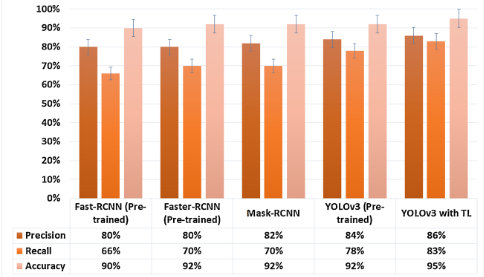

In [ ]:
ax = sns.stripplot(x, y);
ax.set(xlabel ='Accuracy', ylabel ='Epoch')
plt.show()

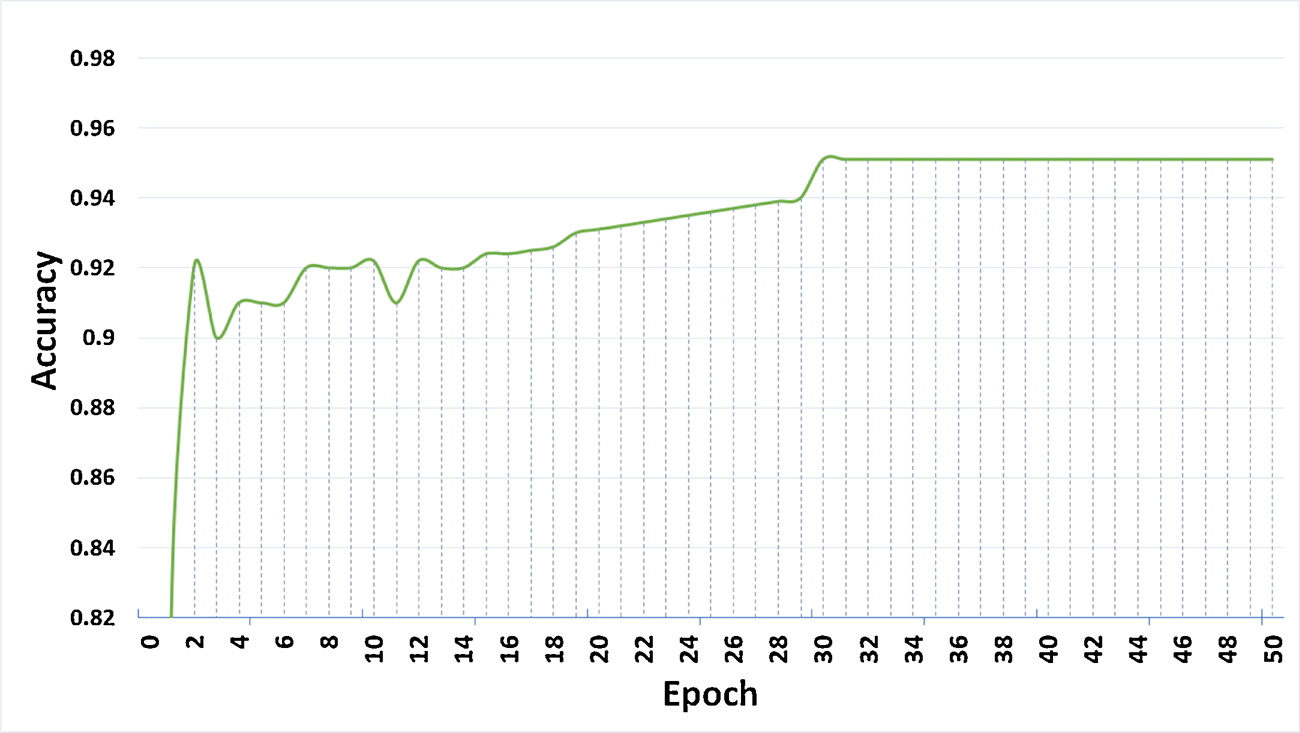